# Substructure challenge - a simple example

This notebooks walks the user through a highly simplified example where a dark lensing subclump is present in projction of an extended strongly lensed arc. All models are analytic and the modelling and mock creation are performed on the same model family. 

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) or via pypi

The packages are based on Birrer, Amara & Refregier 2015 and the official release is presented in  Birrer & Amara 2018.

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

To get to know more about the lenstronomy, please consider also other example notebooks.

In [1]:
# import of standard python libraries and the required lenstronomy modules
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

np.random.seed(41)

## simulation choices
We define the observational conditions and the instrument the mock data is produced with.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


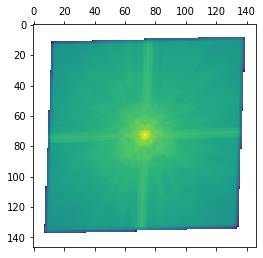

In [2]:

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

    
# data specifics
background_rms = .2  #  background noise per pixel (Gaussian rms value)
exp_time = 80.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 80  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91  # PSF kernel size (odd number required).


# initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)


## defining the model
We define the lens model (macro-model with external shear and a NFW clump) and the light profiles for the source and lens. Theses profiles are highly simplistic and are meant to provide a simple example and is not meant to be applicable for real data sets.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log10


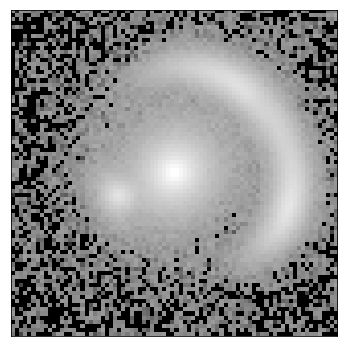

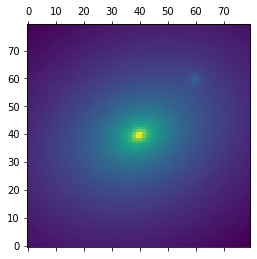

In [3]:
# lensing quantities
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_pemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model
kwargs_nfw = {'alpha_Rs': 0.02, 'Rs': 0.1, 'center_x': 1., 'center_y': 1}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR', 'NFW']
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_x = 0.3
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)


# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

# and here we compute the convergence at each pixel position
x_coords, y_coords = data_class.pixel_coordinates
kappa = lens_model_class.kappa(util.image2array(x_coords), util.image2array(y_coords), kwargs_lens)
plt.matshow(util.array2image(np.log10(kappa)), origin='lower')
plt.show()

# Recovering the input parameters
Now we use lenstronomy to recover the input parameters. First, we want to have a fair estimate of the macro-model parameters and we do not add the NFW subclump.

We define initial guesses, their spread and bounds on all the parameters and run a Particle Swarm Optimization to minimize the $\chi^2$.

In [4]:
# First we only model the macro-model
lens_model_simple_list = ['EPL', 'SHEAR']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1., 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0., 'e2': 0.})
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_simple_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}



# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {}

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                    }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, []]


mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=mpi)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.3728139269493453 reduced X^2 of best position
-4377.903613041462 logL
6378 effective number of data points
[{'theta_E': 1.15877424705001, 'gamma': 2.0552404602373335, 'e1': 0.08291704783410848, 'e2': 0.09971491673299639, 'center_x': 0.006919080291401583, 'center_y': 0.014099054611118303}, {'gamma1': -0.02035571065567936, 'gamma2': -0.07941884523691438, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10715341904457654, 'n_sersic': 1.0001303998846205, 'e1': 0.06691842241104988, 'e2': 0.16131233114616836, 'center_x': 0.3346154227125656, 'center_y': 0.12519151607930812}] source result
[{'amp': 1, 'R_sersic': 0.20032378351629312, 'n_sersic': 2.101706040001737, 'e1': -0.019856459880482843, 'e2': 0.06384332826243079, 'center_x': -0.00040154218370029083, 'center_y': 0.0001006218979783616}] lens light result
[] point source result
{} special param result
118.02126002311707 time used for  PSO
1

## analyse model output
Here we plot the output. Remember, the NFW subclump (which we did not model here) has also an effect on the macro-model that the mcromodel only fitting wants as goog as possible to compensate for. So the recovered macro-model parameters are not going to be identical with the input parameters.

-1.368094879075457 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.3680948790754572


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


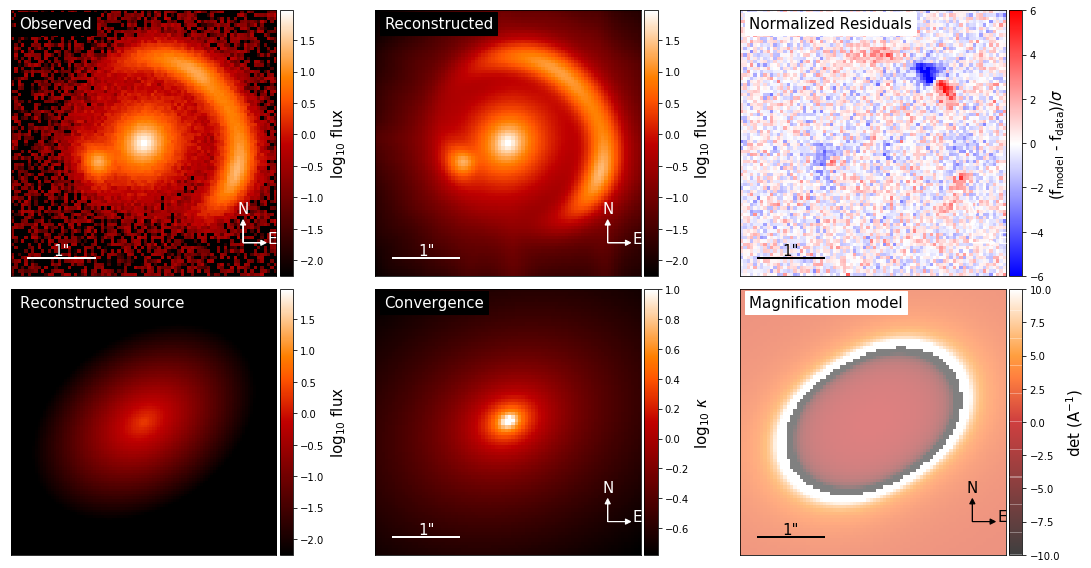

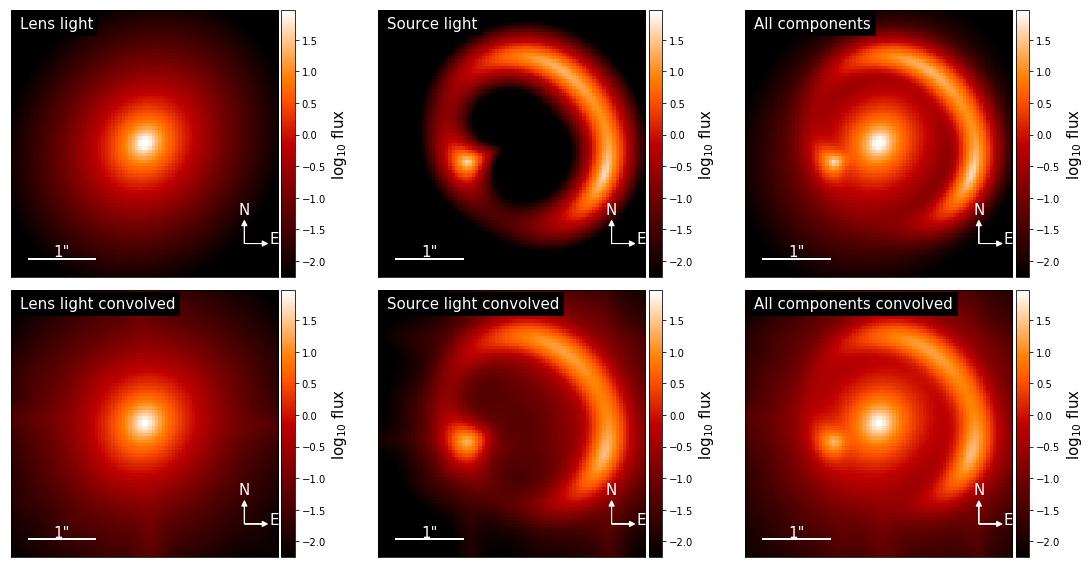

{'kwargs_lens': [{'theta_E': 1.15877424705001, 'gamma': 2.0552404602373335, 'e1': 0.08291704783410848, 'e2': 0.09971491673299639, 'center_x': 0.006919080291401583, 'center_y': 0.014099054611118303}, {'gamma1': -0.02035571065567936, 'gamma2': -0.07941884523691438, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 4259.672195015751, 'R_sersic': 0.10715341904457654, 'n_sersic': 1.0001303998846205, 'e1': 0.06691842241104988, 'e2': 0.16131233114616836, 'center_x': 0.3346154227125656, 'center_y': 0.12519151607930812}], 'kwargs_lens_light': [{'amp': 7858.360037439136, 'R_sersic': 0.20032378351629312, 'n_sersic': 2.101706040001737, 'e1': -0.019856459880482843, 'e2': 0.06384332826243079, 'center_x': -0.00040154218370029083, 'center_y': 0.0001006218979783616}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:517: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


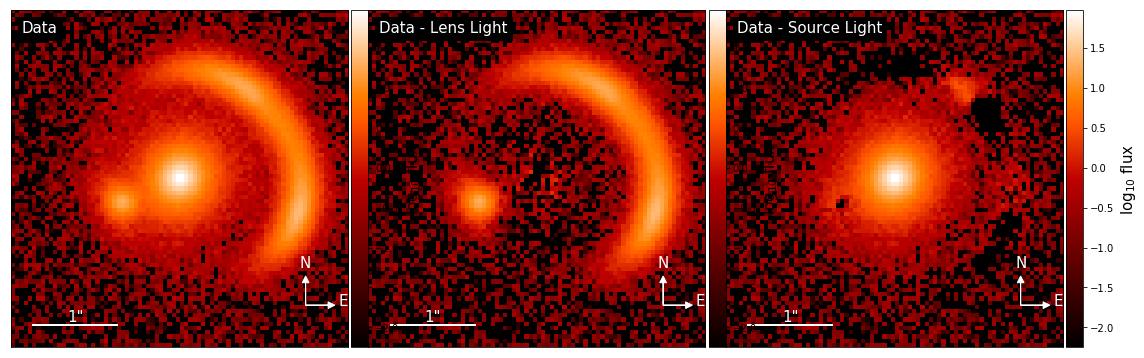

In [5]:
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


## Adding a clump
Now in a second step we add a clump in the lens model. This model is identical (in terms of parameterisation) as the created mock data. The aim now is that the PSO will find the clump at the right position with the right properties. This is a non-trivial convergence problem due to the many covariances also with the macro-model.

In [6]:
# add substructure

lens_model_substructure_list = ['PEMD', 'SHEAR', 'NFW']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2': 0.01, 'gamma': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


fixed_lens.append({})
kwargs_lens_init.append({'alpha_Rs': 0.01, 'Rs': 0.05, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.01, 'Rs': 0.05, 'center_x': 3, 'center_y': 3})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 0.0001, 'center_x': -3, 'center_y': -3})
kwargs_upper_lens.append({'alpha_Rs': 1., 'Rs': 2, 'center_x': 3, 'center_y': 3})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.01, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 800, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.048642008743046 reduced X^2 of best position
-3342.0220818640873 logL
6374 effective number of data points
[{'theta_E': 1.1531112388343479, 'gamma': 2.055813880927015, 'e1': 0.0967927592292438, 'e2': 0.09246380828058107, 'center_x': 0.010782042675936753, 'center_y': 0.007305764933613343}, {'gamma1': -0.011662586620332463, 'gamma2': -0.07080456028293605, 'ra_0': 0, 'dec_0': 0}, {'Rs': 0.07745362551183306, 'alpha_Rs': 0.022902278211279527, 'center_x': 0.9984550214483203, 'center_y': 0.9859919869471072}] lens result
[{'amp': 1, 'R_sersic': 0.10954806871400886, 'n_sersic': 1.0044593665312218, 'e1': 0.05915240630811655, 'e2': 0.11398390851657308, 'center_x': 0.3365706096051604, 'center_y': 0.1170235037974747}] source result
[{'amp': 1, 'R_sersic': 0.20029072775455772, 'n_sersic': 2.007328787164321, 'e1': -0.011388822288622834, 'e2': 0.055955759898125075, 'center_x': 0.00018757703585547123, 'center_y': -

-1.0443819005825272 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0443819005825274


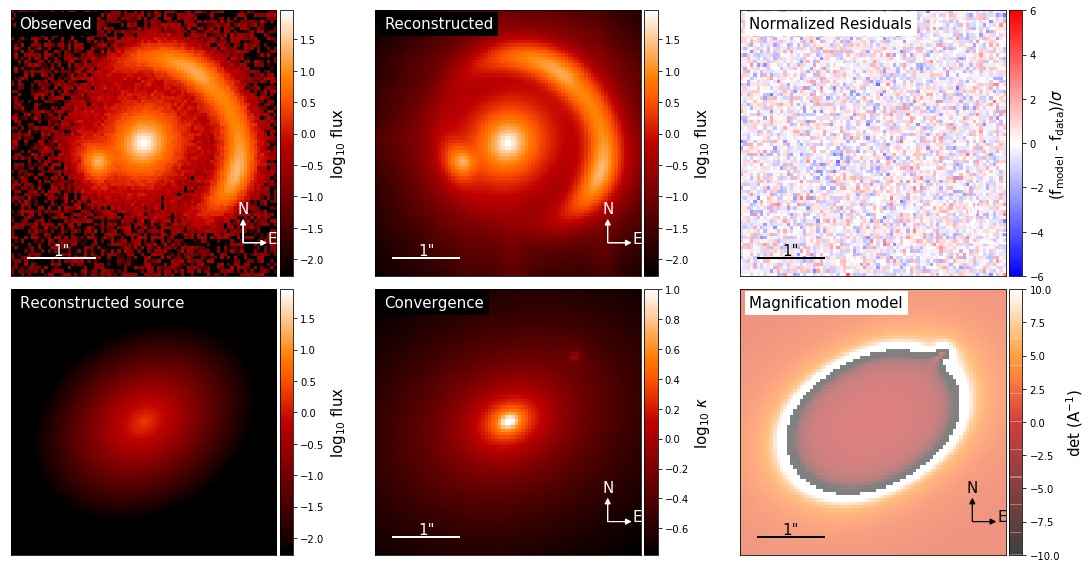

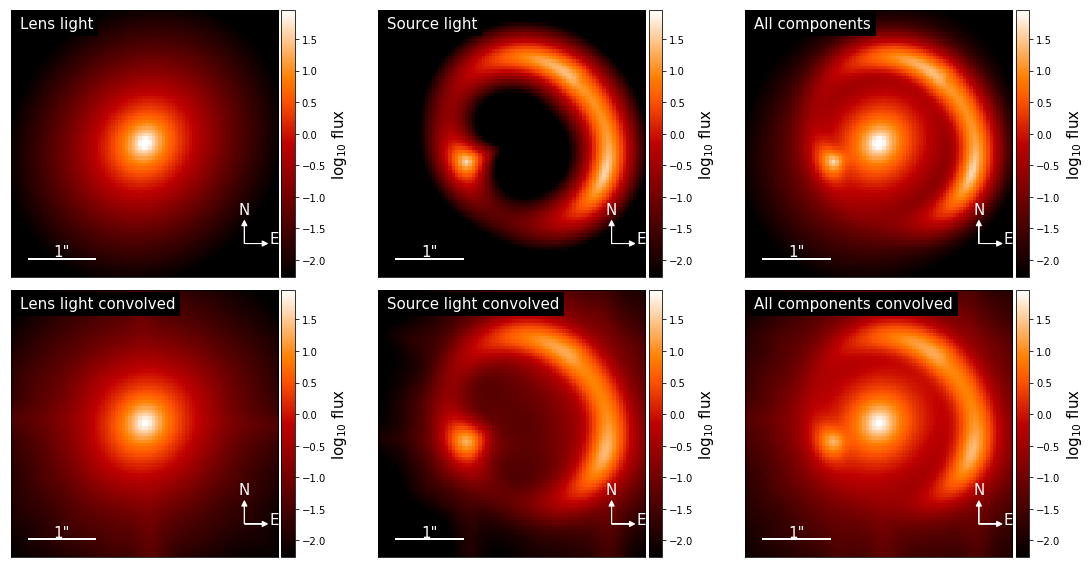

{'kwargs_lens': [{'theta_E': 1.1531112388343479, 'gamma': 2.055813880927015, 'e1': 0.0967927592292438, 'e2': 0.09246380828058107, 'center_x': 0.010782042675936753, 'center_y': 0.007305764933613343}, {'gamma1': -0.011662586620332463, 'gamma2': -0.07080456028293605, 'ra_0': 0, 'dec_0': 0}, {'Rs': 0.07745362551183306, 'alpha_Rs': 0.022902278211279527, 'center_x': 0.9984550214483203, 'center_y': 0.9859919869471072}], 'kwargs_source': [{'amp': 4003.998087962464, 'R_sersic': 0.10954806871400886, 'n_sersic': 1.0044593665312218, 'e1': 0.05915240630811655, 'e2': 0.11398390851657308, 'center_x': 0.3365706096051604, 'center_y': 0.1170235037974747}], 'kwargs_lens_light': [{'amp': 7969.71567054782, 'R_sersic': 0.20029072775455772, 'n_sersic': 2.007328787164321, 'e1': -0.011388822288622834, 'e2': 0.055955759898125075, 'center_x': 0.00018757703585547123, 'center_y': -0.0004695886999326202}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


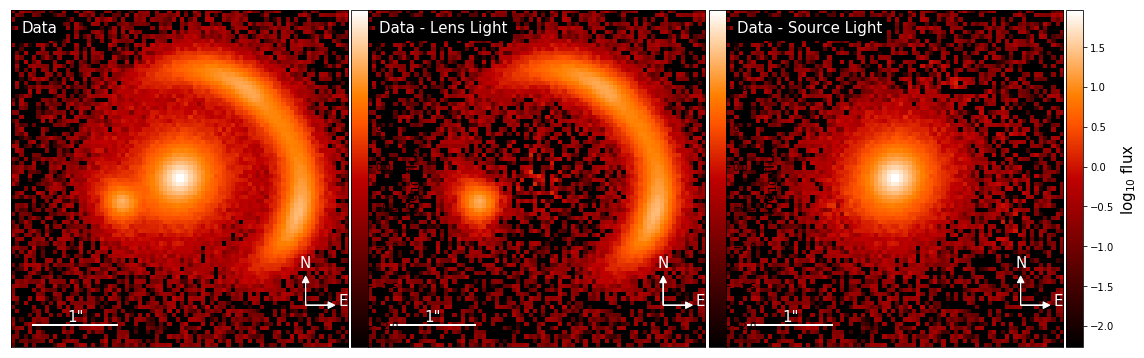

In [7]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

## MCMC of the parameter space
after convergence (please check) we run an MCMC sampler (emcee with CosmoHammer)

In [8]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2': 0.01, 'gamma': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


fixed_lens.append({})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][2])
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.05, 'Rs': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 0.0001, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens.append({'alpha_Rs': 1., 'Rs': 2, 'center_x': 2, 'center_y': 2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 200, 'n_run': 200, 'walkerRatio': 6, 'sigma_scale': 0.1}]]
start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')



100%|██████████| 400/400 [07:16<00:00,  1.09s/it]

Computing the MCMC...
Number of walkers =  144
Burn-in iterations:  200
Sampling iterations (in current run): 400
437.2473669052124 time taken for MCMC sampling
437.2532088756561 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


number of non-linear parameters in the MCMC process:  24
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'Rs_lens2', 'alpha_Rs_lens2', 'center_x_lens2', 'center_y_lens2', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  28800


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


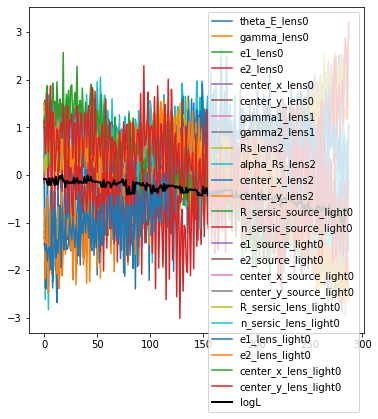

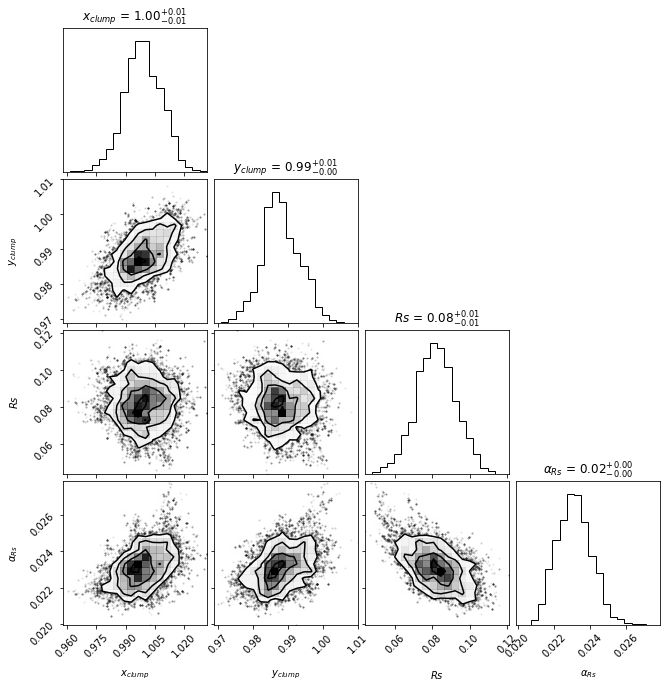

In [9]:
from lenstronomy.Plots import chain_plot

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, kwargs_lens_init=kwargs_lens, **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$x_{clump}$", r"$y_{clump}$", r"$Rs$", r"$\alpha_{Rs}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    mcmc_new_list.append([kwargs_result['kwargs_lens'][2]['center_x'], 
                          kwargs_result['kwargs_lens'][2]['center_y'], 
                          kwargs_result['kwargs_lens'][2]['Rs'], 
                          kwargs_result['kwargs_lens'][2]['alpha_Rs']])

fig = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)
fig.show()